In [ ]:
import os

from fastai.vision.all import *
from fastai.vision import *
from fastai.callback.data import OverSamplingCallback

import pandas as pd
import PIL

In [ ]:
TRAIN_DATASET_PATH = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train"
TEST_DATASET_PATH = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/test"

print(f"Train dataset path: {TRAIN_DATASET_PATH}")
print(f"Test dataset path: {TEST_DATASET_PATH}")


Train dataset path: /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/train_test/train
Test dataset path: /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/train_test/test


In [ ]:
# models to compare 
available_models = {
    'alexnet': models.alexnet,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    'densenet201': models.densenet201,
}

## Images Transformation Experiment
I want to compare the results when performing transformations like resize or color shifting for the images to see if I can get better results.
I will use a slim model to run the comparisons faster.

In [ ]:
# model and metrics to compare
model_name = 'alexnet'
precision_macro = Precision(average='macro')
recall_macro = Recall(average='macro')
precision_micro = Precision(average='micro')
recall_micro = RecallMulti(average='micro')
roc_auc = RocAuc()

epochs = 10
batch_size = 16
valid_pct = 0.25
resize = Resize(128)


Raw dataloader

In [ ]:
# create raw dataloader
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=resize,
    bs=batch_size,
    valid_pct=valid_pct
)

model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=epochs
)

Resize the Image to 128 with padding

In [ ]:

# Custom transform
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

# DataLoaders with custom transform
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(128),  # Adjust size as needed
    batch_tfms=aug_transforms(size=128),  # Apply data augmentation
    bs=batch_size, 
    valid_pct=valid_pct
)

model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=epochs
)


Convert the images to HSV

In [ ]:
# Custom Transform to HSV using fastai's rgb2hsv
class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)
    
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[RGB2HSV(), *aug_transforms(size=128)],
    bs=batch_size,
    valid_pct=valid_pct
)

model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=epochs
)


Normalize the images pixels

In [ ]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=128)],
    bs=batch_size,
    valid_pct=valid_pct
)

model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=epochs
)

Brightness and Contrast Adjustments

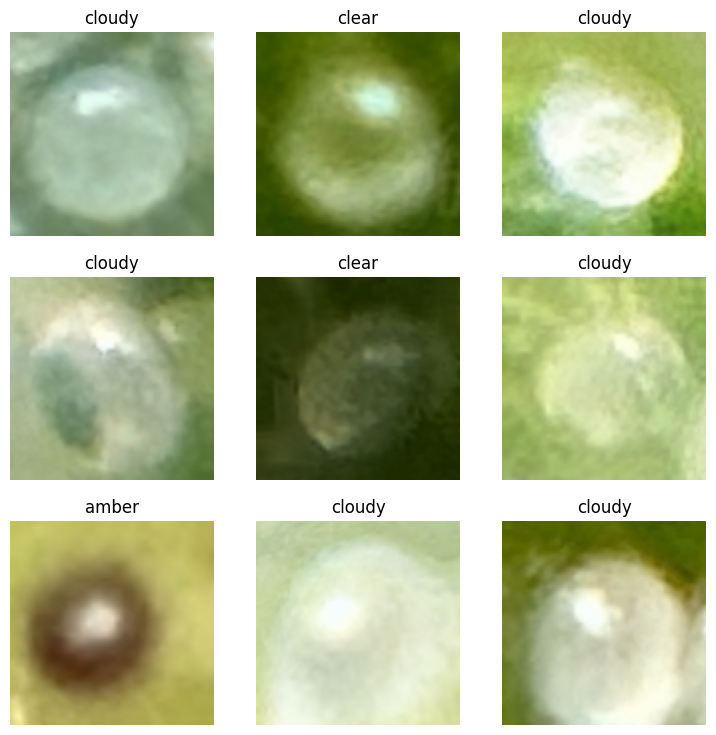

In [ ]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=resize, 
    batch_tfms=[Brightness(max_lighting=0.2, p=0.75), Contrast(max_lighting=0.2, p=0.75), *aug_transforms(size=128)],
    bs=batch_size,
    valid_pct=valid_pct
)

model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=epochs
)


Combined Transformations

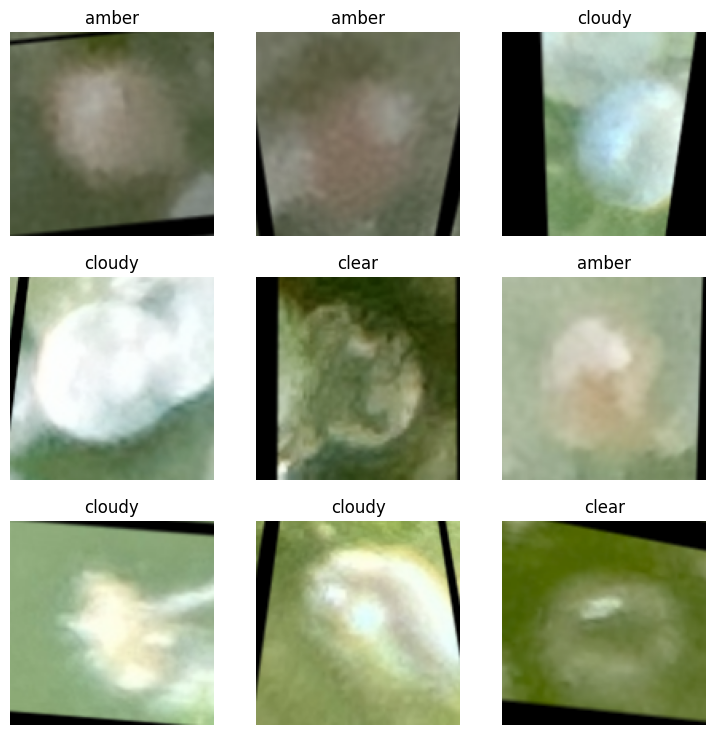

In [ ]:
# Custom transform
def custom_transform(size):
    return Resize(size, method="pad", pad_mode="zeros")


class RGB2HSV(Transform):
    def encodes(self, img: PILImage):
        return rgb2hsv(img)


dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),  # Resize and HSV transform
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=batch_size,
    valid_pct=valid_pct,
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()


model = vision_learner(
    dls=dls,
    arch=available_models["resnet34"],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc],
    cbs=OverSamplingCallback(),
)

model.fine_tune(epochs=epochs)

In [ ]:
model_saving_path = '/home/etaylor/code_projects/thesis/checkpoints/trichome_image_classification'
model_checkpoint = f'{model_saving_path}/{model_name}.pkl'
model.export(model_checkpoint)

In [ ]:
from fastai.vision.all import load_learner

model = load_learner(model_checkpoint)


In [ ]:
classes = dls.vocab
class_ids = dls.vocab.o2i

print("Classes:", classes)
print("Class IDs:", class_ids)


Classes: ['amber', 'clear', 'cloudy']
Class IDs: {'amber': 0, 'clear': 1, 'cloudy': 2}
